## MIIA-4203 MODELOS AVANZADOS PARA ANÁLISIS DE DATOS II
# Micro-Proyecto 1

### Profesor: Camilo Franco (c.franco31@uniandes.edu.co)

A continuación escriba los nombres de los integrantes del grupo.

Nombres: 

### Daniel León 201920439 - David Tavera 201016123 - Grupo 14


### Introducción
Una *start-up* agrícola quiere construir una aplicación online que conecte el campo
con la ciudad de manera directa y sin intermediarios. De esta manera, los agricultores ponen a la disposición de la empresa sus distintos productos, y la start-up se encarga de atender las necesidades de demanda distribuyendo los productos hasta los clientes finales en la ciudad.

Para optimizar la gestión logística y desarrollar esta labor de manera eficiente, los dueños de la *start-up* han visto la necesidad de diseñar e implementar un sistema de gestión y predicción que les permita planear con la debida anticipación la demanda esperada. Así podrán coordinar las actividades de producción, junto con los agricultores, y atender la demanda mientras se minimizan las pérdidas por unidades de producto no vendido o estropeado. 

Este es un reto altamente relevante para la sostenibilidad de la industria alimentaria, donde gran cantidad de las pérdidas se refieren a grupos alimenticios donde la frescura del producto es un importante criterio para el consumo. El desperdicio de los alimentos se relaciona con el sobre-pedido o el sobre-almacenamiento, lo cual puede a su vez ser consecuencia de dificultades en el pronóstico de la demanda. Este problema es aun más marcado a medida que uno sube en la cadena de producción y se aleja de los patrones de comportamiento del consumidor final. 

Por lo tanto, la start-up agrícola debe gestionar los inventarios de manera inteligente, disminuyendo la ventana de tiempo entre cosecha y consumo. Para ello, necesita desarrollar modelos de predicción de demanda que apoyen su operación, logrando la disponibilidad de los productos para atender a los clientes del día siguiente, minimizando los desperdicios de alimentos e identificando hábitos de consumo que le permita optimizar sus operaciones logísticas y de negocio.

### Enunciado
Por ello se le pide a usted, en calidad de consultor externo, desarrollar un modelo predictivo de demanda para los productos más relevantes con los que trabaja la start-up agrícola, obteniendo una predicción a nivel semanal (una semana adelante). Los datos los encuentra en el archivo DatosAgro.txt, donde se tiene la identificación del cliente, la fecha en que realizó el pedido, la magnitud del pedido (en unidades según lo especificado en el nombre del producto), su precio, y el código del producto agrícola que consta en el pedido.

## 1. Visualicemos los datos

In [1]:
import pandas as pd
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# Importemos los datos y visualizemos la serie de tiempo
data = pd.read_csv("DatosAgro.txt", delimiter='\t', encoding="utf8")
data = data.drop('Unnamed: 6', 1)
data.head()

,Cliente,Fecha,Pedido,Precio,Producto,Nombre_producto
0,Cliente26,18/09/2017,20,700,VER0049,Yerbabuena / 100 gramos
1,Cliente26,18/09/2017,10,1200,FRU0024,Limón Tahití / Libra
2,Cliente26,18/09/2017,4,1600,VER0041,Puerro / Libra
3,Cliente26,18/09/2017,10,1500,VER0038,Pimentón Rojo / Libra
4,Cliente26,18/09/2017,8,1100,VER0010,Zucchini Verde / Libra


Veamos los clientes con mayor participación en la demanda:

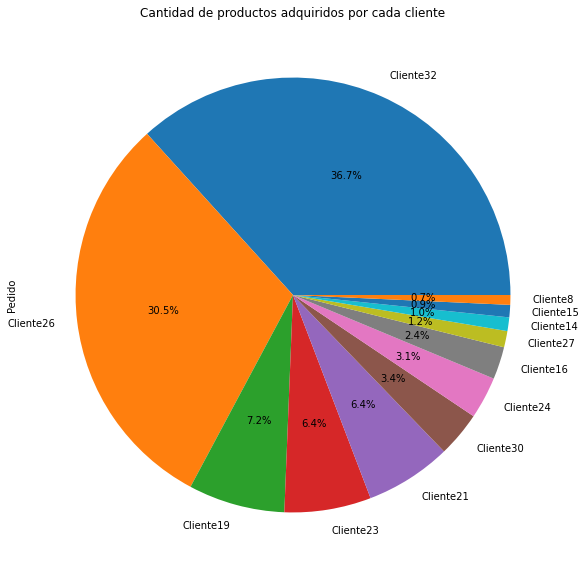

In [3]:
cliente = pd.DataFrame(data[data['Pedido'] > 10].groupby(data["Cliente"]).sum())
cliente2 = cliente[cliente['Pedido']>50]
cliente3 = cliente2.sort_values("Pedido", ascending= False)
cliente3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%')
plt.title("Cantidad de productos adquiridos por cada cliente")
plt.show()

Vemaos los productos con más volumen de pedido:

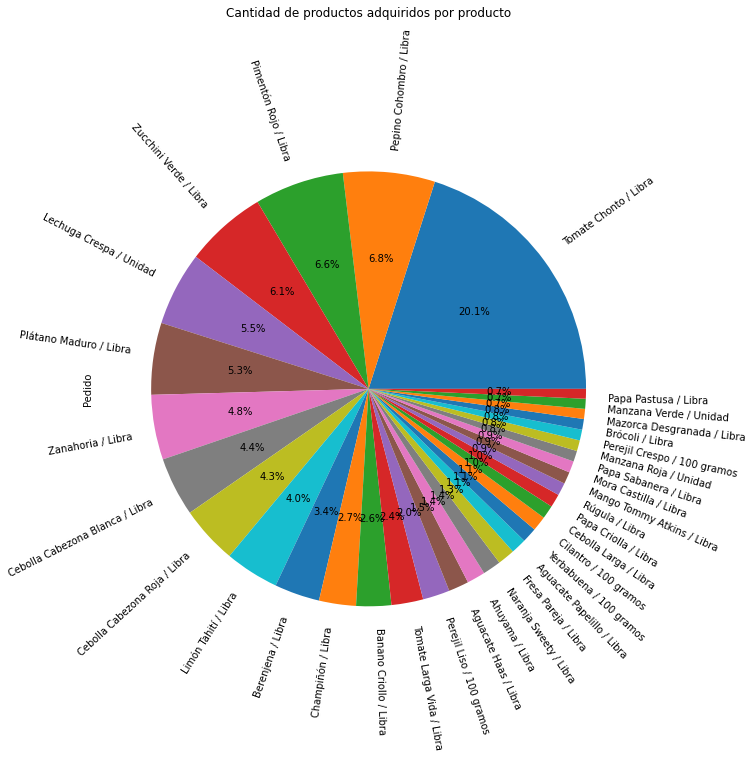

In [4]:
productos = pd.DataFrame(data["Pedido"].groupby(data["Nombre_producto"]).sum())
productos2 = productos[productos['Pedido']>140]
productos3 = productos2.sort_values("Pedido", ascending= False)
productos3.plot.pie(y='Pedido', figsize=(10, 10), legend=False, autopct='%1.1f%%', rotatelabels=True)
plt.title("Cantidad de productos adquiridos por producto", pad=100)
plt.show()

A continuación implemente la metodología propuesta para construir su modelo:

### Descriptivos

In [5]:
#### Revisamos tipos para cada columna
data.dtypes

Cliente            object
Fecha              object
Pedido              int64
Precio              int64
Producto           object
Nombre_producto    object
dtype: object

In [6]:
#### Convertimos columna fecha a datetime
data['Fecha'] = pd.to_datetime(data['Fecha'],format='%d/%m/%Y')

In [7]:
#### Numero de productos distintos con demanda
print(len(data['Producto'].unique()),'productos distintos')

121 productos distintos


In [8]:
#### Fecha inicial del registro historico
print('Fecha inicial:',min(data['Fecha']))

Fecha inicial: 2016-11-03 00:00:00


In [9]:
#### Fecha inicial del registro historico
print('Fecha inicial:',max(data['Fecha']))

Fecha inicial: 2017-09-18 00:00:00


Podemos observar que el periodo de tiempo a considerar es de cerca de 11 meses.

### Definición productos más relevantes

Con el objetivo de desarrollar los modelos predictivos de demanda para los productos más relevantes con los que trabaja la start-up agrícola, es necesario definir la métrica con la cual se seleccionarán los productos más relevantes y así obtener el listado de productos resultantes que serán considerados.

De esta manera, y teniendo en cuenta la información disponible, tenemos las siguientes opciones de métricas: 

- Productos con la mayor cantidad de pedidos.
- Productos con el mayor volumen de ventas (en dinero).
- Productos con la mayor cantidad de unidades vendidas.

Podemos observar que cualquiera de las métricas anteriores permitirían definir los productos más relevantes para la empresa, sin embargo, consideramos que la métrica más adecuada es identificar los productos con la mayor cantidad de pedidos debido a que el volumen de ventas depende del precio intrínseco del producto, así como el número de unidades vendidas. En cambio, el número de pedidos permite identificar la frecuencia e interés de compra del producto, independientemente de su valor o unidades vendidas.

In [10]:
#### Filtro del dataset con los productos más relevantes

### Obtener la cantidad de pedidos por producto
cantidad = data[['Pedido','Nombre_producto']].groupby(['Nombre_producto']).count()

### Definimos el listado de productos relevantes a partir de los productos del percentil 75 en adelante.
cantidad['Pedido'].describe()

count    121.000000
mean      38.942149
std       53.459221
min        1.000000
25%        8.000000
50%       20.000000
75%       48.000000
max      355.000000
Name: Pedido, dtype: float64

Definimos los productos relevantes como aquellos con una frecuencia de compra mayor a 48 pedidos.

In [11]:
### Creacion del listado de productos mas relevantes
pdtos_rel = cantidad[cantidad['Pedido']>=48]

### Filtro dataset con el listado de productos mas relevantes
data2 = data[data['Nombre_producto'].isin(pdtos_rel.index)]

### Agrupamos las compras por semana y producto
data2 = data2[['Nombre_producto','Fecha','Pedido']].groupby(['Nombre_producto']).resample('W-Mon', on='Fecha').sum().reset_index()

### Metodología
Con el objetivo de determinar el mejor tipo de modelo para cada producto del listado a considerar, se probará un modelo ARIMA y un modelo con el algoritmo Prophet para cada uno de los 31 productos más relevantes, y luego se elegirá el modelo para cada producto que minimiza el RMSE. 

Los modelos ARIMA serán considerados por ser los modelos de series de tiempo más utilizados y con más trayectoria en el mundo de la economía y de las finanzas. Puntualmente, se calibrarán distintos modelos ARIMA para cada producto a partir de hacer Grid Search a los hiperparámetros del modelo, es decir, probar diferentes calibraciones del modelo ARIMA para conseguir aquel que disminuye en mayor medida el error.

Por otro lado, probaremos modelos con el algoritmo Prophet, desarrollado por Facebook, el cual ha generado buenas opiniones entre la comunidad interesada pues genera buenos resultados. De manera detallada, Prophet es un procedimiento para pronosticar datos de series de tiempo basado en un modelo aditivo donde las tendencias no lineales se ajustan a la estacionalidad anual, semanal y diaria, más los efectos de los días festivos. Prophet es robusto ante los datos faltantes y los cambios de tendencia, y normalmente maneja bien los valores atípicos. Información adicional acerca de Prophet puede ser consultada en el siguiente enlace https://facebook.github.io/prophet/

### Construcción función de selección mejor modelo

A continuación construiremos una función para seleccionar el mejor modelo para cada producto relevante. La función consistirá en encontrar el modelo ARIMA que mejor minimice el RMSE, luego se ajustará el modelo Prophet para luego elegir el mejor modelo entre ambos.

In [12]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
import itertools
import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [13]:
def gridSearchTS(producto):

    ### Transformacion de datos
    # Organizamos los datos segun fecha
    producto = producto.sort_values(by=['Fecha'])
    # Definimos los datos para train y test
    X = producto['Pedido'].values
    tamaño = int(len(X) - 2)
    train, test = X[0:tamaño], X[tamaño:len(X)]

    ### Estimacion modelos ARIMA
    # Definimos los parametros p, d y q para probar valores entre 0 y 5
    p = d = q = range(0, 6)
    # Generamos todas las posibles combinaciones de los parametros
    pdq = list(itertools.product(p, d, q))
    mejoresParam = None
    menorRMSE = np.inf
    # Generamos modelos ARIMA para cada posible combinacion
    for param in pdq:
        try:
            mod = ARIMA(train,order=param)
            mod_fit = mod.fit(disp=0)
            pronosticos = mod_fit.forecast(len(test))[0]
            error = mean_squared_error(test, pronosticos, squared=False)
            if error < menorRMSE:
                menorRMSE = error
                mejoresParam = param
        except:
            continue

    ### Estimacion modelos Prophet                
    df = pd.DataFrame()
    df['y'] = producto['Pedido'][0:tamaño]
    df['ds'] = producto['Fecha'][0:tamaño]

    mod2 = Prophet()
    mod2.fit(df)
    future = mod2.make_future_dataframe(periods=2, freq='W')
    pronosticos2 = mod2.predict(future)
    pronosticos2 = pronosticos2['yhat'][-len(test):]
    error2 = mean_squared_error(test, pronosticos2, squared=False)
    
    ### Creacion del dataframe de salida
    df = pd.DataFrame(np.array([[None,None,None,None]]),columns=['producto','modelo','RMSE','confg'])
    
    ### Definicion mejor modelo
    if menorRMSE < error2:
        df['producto'] = producto['Nombre_producto'].iloc[0]
        df['modelo'] = 'ARIMA'
        df['RMSE'] = menorRMSE
        df['confg'] = ARIMA(train,order=mejoresParam).fit(disp=0)
    else:
        df['producto'] = producto['Nombre_producto'].iloc[0]
        df['modelo'] = 'Prophet'
        df['RMSE'] = error2
        df['confg'] = mod2
    return df

### Resultados
Luego de probar los diferentes modelos para cada uno de los productos relevantes, y de seleccionar el modelo que minimiza el RMSE, obtenemos los siguientes resultados. 

In [14]:
### Inicializamos las listas donde guardaremos la informacion de los diferentes productos
df = pd.DataFrame(columns=['producto','modelo','RMSE','confg'])

### Definicion mejor modelo para cada producto
for producto in pdtos_rel.index:
    temp = gridSearchTS(data2[['Fecha','Pedido','Nombre_producto']][data2['Nombre_producto']==producto])
    df = df.append(temp)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_s

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_sea

In [15]:
## Conteo por tipo de mejor modelo
df['modelo'].value_counts()

ARIMA      30
Prophet     1
Name: modelo, dtype: int64

In [16]:
## Descriptivos RMSE
df['RMSE'].describe()

count    31.000000
mean      2.185146
std       3.430723
min       0.037797
25%       0.572619
50%       1.070077
75%       2.386459
max      18.652794
Name: RMSE, dtype: float64

In [17]:
## Listado detallado con la informacion para cada producto
df

,producto,modelo,RMSE,confg
0,Aguacate Papelillo / Libra,ARIMA,0.437780,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Apio / Libra,ARIMA,0.231642,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Arracacha / Libra,ARIMA,0.602999,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
0,Banano Criollo / Libra,ARIMA,4.920125,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Berenjena / Libra,ARIMA,0.641762,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Brócoli / Libra,ARIMA,0.674216,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Cebolla Cabezona Blanca / Libra,ARIMA,2.316908,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Cebolla Cabezona Roja / Libra,ARIMA,1.607843,<statsmodels.tsa.arima_model.ARMAResultsWrappe...
0,Cebolla Larga / Libra,ARIMA,1.448851,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...
0,Champiñón / Libra,ARIMA,0.384467,<statsmodels.tsa.arima_model.ARIMAResultsWrapp...


Podemos observar que 30 de los 31 productos relevantes obtuvieron como mejor modelo de predicción un modelo ARIMA, mientras que solo un producto obtuvo mejores resultados con un modelo Prophet. Asimismo, el RMSE promedio alcanzado es de 2.185 unidades pedidas, con una desviación de 3.431 unidades, es decir, logramos implementar un set de modelos de predicción de demanda con un error semanal promedio en la estimación de 2.185 unidades, lo cual permitirá minimizar los desperdicios de alimentos y optimizar las operaciones logísticas y de negocio de la start-up.

#### Generacion y guardado predicción semanal para cada producto

In [29]:
### Guardamos las predicciones en un diccionario
predicciones = {}
for x, producto in enumerate(df['producto']):
    if df['modelo'].iloc[x] == 'ARIMA':
        predicciones[str(producto)] = df['confg'].iloc[x].forecast(1)[0]
    else:
        mod = df['confg'].iloc[x]
        future = mod.make_future_dataframe(periods=1, freq='W')
        pronosticos = mod.predict(future)
        predicciones[str(producto)] = pronosticos['yhat'][-1:]

In [32]:
### Visualizamos las predicciones para cada producto
for producto in predicciones:
    print('Producto:',producto)
    print('Valor predicho semanal:',predicciones[producto],'unidades')
    print()

Producto: Aguacate Papelillo / Libra
Valor predicho semanal: [8.27379558] unidades

Producto: Apio / Libra
Valor predicho semanal: [5.1560232] unidades

Producto: Arracacha / Libra
Valor predicho semanal: [5.85909286] unidades

Producto: Banano Criollo / Libra
Valor predicho semanal: [22.04303517] unidades

Producto: Berenjena / Libra
Valor predicho semanal: [15.7249501] unidades

Producto: Brócoli / Libra
Valor predicho semanal: [7.91495197] unidades

Producto: Cebolla Cabezona Blanca / Libra
Valor predicho semanal: [108.27449794] unidades

Producto: Cebolla Cabezona Roja / Libra
Valor predicho semanal: [27.23314139] unidades

Producto: Cebolla Larga / Libra
Valor predicho semanal: [11.825081] unidades

Producto: Champiñón / Libra
Valor predicho semanal: [24.55400285] unidades

Producto: Cilantro / 100 gramos
Valor predicho semanal: [8.73145898] unidades

Producto: Espinaca / Libra
Valor predicho semanal: [4.24380328] unidades

Producto: Fresa Pareja / Libra
Valor predicho semanal: [1

Podemos observar que en el diccionario creado anteriormente ya tenemos guardadas las predicciones generadas para cada producto.

### Conclusiones

Las herramientas de analítica y ciencia de datos en general abarcan una amplia variedad de alternativas para analizar los datos en función de nuestros distintos intereses, por ejemplo herramientas enfocadas en el análisis de series de tiempo que permiten realizar predicciones de demanda, como es el caso de los modelos generados para este proyecto. Sin embargo, aunque cada vez más un creciente número de empresas entienden la importancia y el poder que tiene la aplicación de analítica en las distintas verticales y problemas de negocio, aun falta recorrer un largo camino para llevar el poder de la analítica a cada empresa que se plantee resolver problemas a través del uso de los datos. En este sentido es un gran acierto para la start-up agrícola tomar la de decisión de incluir la analítica en su modelo de negocio con el objetivo de minimizar sus desperdicios de alimentos y optimizar sus operaciones logísticas.

De manera detallada, fue posible observar que mediante el ajuste de distintos modelos de predicción de demanda y la selección del mejor modelo para cada producto fue posible cumplir con el objetivo de generar predicciones semanales de la demanda de cada producto con herramientas robustas y probadas. Con esto y, en nuestro rol de consultores, esperamos que la start-up siga minimizando perdidas y optimizando sus operaciones, haciendo uso de las herramientas de predicción de demanda desarrolladas para ellos.

De igual manera, si la start-up lo considera conveniente pueden implementarse otros modelos de predicción de demanda basados en redes neuronales por ejemplo, y evaluar su desempeño al comparar sus resultados con los modelos actuales, con el objetivo de obtener modelos cada vez más precisos.

Por otro lado, se recomienda en un futuro considerar también la implementación de otras herramientas de analítica que ayudarían enormemente a la empresa, como herramientas de Customer Churn Analysis y Estrategias de fijación de precios por citar algunos ejemplos, que permitirían conocer mejor al cliente y generar mejores resultados comerciales.